## load libs

In [1]:
import cpufeature as cpufeature
import dcimg as dcimg
import numba as numba
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from process_images import *
from pystripe.core import *
import matplotlib.pyplot as plt
def plot_images(img_list: List[ndarray], img_labels: List[str], vmax: int):
    fig, axes = plt.subplots(nrows=1, ncols=len(img_list), figsize=(20, 20))
    for idx, (im, label) in enumerate(zip(img_list, img_labels)):
        axes[idx].imshow(im, cmap='gray', vmin=0, vmax=vmax)
        axes[idx].set_title(label)
    plt.tight_layout()
    plt.show()

In [2]:
from parallel_image_processor import *
tsv_volume = TSVVolume.load(r'E:\20230510_13_34_13_SM230308_05_LS_15x_800z_MIP_stitched\Ex_488_Em_525_MIP_xml_import_step_5.xml')
shape: Tuple[int, int, int] = tsv_volume.volume.shape  # shape is in z y x format
img = tsv_volume.imread(
    VExtent(
        tsv_volume.volume.x0, tsv_volume.volume.x1,
        tsv_volume.volume.y0, tsv_volume.volume.y1,
        tsv_volume.volume.z0 + shape[0]//2, tsv_volume.volume.z0 + shape[0]//2 + 1),
    tsv_volume.dtype)[0]
parallel_image_processor(
    source=TSVVolume.load(r'/data/20230419_17_34_03_SM221011_06_LS_15x_800z_stitched/Ex_488_Em_525_xml_import_step_5.xml'),
    destination=r"/data/20230419_17_34_03_SM221011_06_LS_15x_800z_stitched/Ex_488_Em_525_tif",
    fun=process_img,
    kwargs={'bleach_correction_frequency': 0.0005, 'bleach_correction_max_method': False, 'bleach_correction_y_slice_max': None, 'threshold': None, 'sigma': (4000.0, 4000.0), 'bidirectional': True, 'lightsheet': False, 'percentile': 0.25, 'rotate': 90, 'convert_to_8bit': False, 'bit_shift_to_right': 8, 'tile_size': (39220, 28056), 'd_type': 'uint16', "verbose": True},
    source_voxel=(0.8, 0.4, 0.4),
    target_voxel=20,
    max_processors=1
)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\20230510_13_34_13_SM230308_05_LS_15x_800z_MIP_stitched\\Ex_488_Em_525_MIP_xml_import_step_5.xml'

In [3]:
img_paths = [
    Path("./tempData/cha1"),
    Path("./tempData/cha2"),
    Path("./tempData/cha3")
]
output_path = Path("./tempData/merged")
merge_all_channels(img_paths, output_path)

tempData\merged\img_000000.tif
tempData\merged\img_000001.tif
tempData\merged\img_000002.tif
tempData\merged\img_000003.tif
tempData\merged\img_000004.tif
tempData\merged\img_000005.tif
tempData\merged\img_000006.tif
tempData\merged\img_000007.tif
tempData\merged\img_000008.tif
tempData\merged\img_000009.tif
tempData\merged\img_000010.tif
tempData\merged\img_000011.tif
tempData\merged\img_000012.tif
tempData\merged\img_000013.tif
tempData\merged\img_000014.tif
tempData\merged\img_000015.tif
tempData\merged\img_000016.tif
tempData\merged\img_000017.tif
tempData\merged\img_000018.tif
tempData\merged\img_000019.tif
tempData\merged\img_000020.tif
tempData\merged\img_000021.tif
tempData\merged\img_000022.tif
tempData\merged\img_000023.tif
tempData\merged\img_000024.tif
tempData\merged\img_000025.tif
tempData\merged\img_000026.tif
tempData\merged\img_000027.tif
tempData\merged\img_000028.tif
tempData\merged\img_000029.tif
tempData\merged\img_000030.tif
tempData\merged\img_000031.tif
tempData

RGB: 100%|##########| 791/791 [06:40<00:00,  1.98 images/s]


In [2]:
def get_layer(
    index: int,          # layer of image requested
    image: ndarray,      # 3-D image (use TifStack.as_3d_numpy())
    plane = "xy",        # must be "xy", "yx", "xz", "zx", "yz", "zy"
    img_format = "zyx",  # xyz in some order
):
    # guards
    if plane not in {"xy", "yx", "xz", "zx", "yz", "zy"} or img_format not in {"zyx", "zxy", "yxz", "yzx", "xyz", "xzy"}:
        print(f"Invalid plane selected in get_layer().  Plane: {plane}, Layer: {index}, Img_format: {img_format}\nReturning to caller...")
        return None

    # get the layer
    if 'x' not in plane:   sub = img_format.index('x')
    elif 'y' not in plane: sub = img_format.index('y')
    elif 'z' not in plane: sub = img_format.index('z')

    if sub == 0:   layer_image = image[index, :, :]
    elif sub == 1: layer_image = image[:, index, :]
    elif sub == 2: layer_image = image[:, :, index]

    # if plane is flipped compared to image format, return the transpose.
    if plane not in (img_format[:sub] + img_format[sub + 1:]):
        return layer_image.transpose()
    return layer_image

def get_matrices(
        tif_paths: List[Path],
        z_offsets: List[int],
        img_reference_idx: int,
        right_bit_shifts: Union[Tuple[int, ...], None] = None,
        silent=True
):
    z_offsets = [0] + z_offsets
    assert len(tif_paths) == len(z_offsets)
    if right_bit_shifts is not None:
        assert len(right_bit_shifts) == len(tif_paths)
    with Pool(len(tif_paths)) as pool:
        tif_stacks = list(pool.starmap(TifStack, zip(tif_paths, z_offsets)))
        assert all([tif_stack.nz > 0 for tif_stack in tif_stacks])
        # img_reference_idx = tif_stacks[0].nz // 2
        if not silent: print(f"reference image index = {img_reference_idx}")
        assert img_reference_idx >= 0
        img_samples = pool.starmap(imread_tif_stck, zip(tif_stacks, (img_reference_idx,) * len(tif_paths)))
        img_samples = list(pool.map(get_gradient, img_samples))
    assert all([img is not None for img in img_samples])
    transformation_matrices = [get_transformation_matrix(img_samples[0], img) for img in img_samples[1:]]
    del img_samples
    return transformation_matrices

In [3]:
# run to rotate images
from os import makedirs

######## CHANGE THESE ########
cha1_path = "D:/BMAP/Brain 4/cha1"
cha2_path = "D:/BMAP/Brain 4/cha2"
cha3_path = "D:/BMAP/Brain 4/cha3"
# set to None if nothing to convert

##############################
if cha1_path:
    makedirs(cha1_path + "_zx", exist_ok=True)
    makedirs(cha1_path + "_zy", exist_ok=True)
    stack1 = TifStack(cha1_path).as_3d_numpy()
    for i in range(stack1.shape[1]):
        imwrite(cha1_path + "_zx/" + str(i + 1) + ".tif", get_layer(i, stack1, "zx"))
    for i in range(stack1.shape[2]):
        imwrite(cha1_path + "_zy/" + str(i + 1) + ".tif", get_layer(i, stack1, "zy"))
if cha2_path:
    makedirs(cha2_path + "_zx", exist_ok=True)
    makedirs(cha2_path + "_zy", exist_ok=True)
    stack2 = TifStack(cha2_path).as_3d_numpy()
    for i in range(stack2.shape[1]):
        imwrite(cha2_path + "_zx/" + str(i + 1) + ".tif", get_layer(i, stack2, "zx"))
    for i in range(stack2.shape[2]):
        imwrite(cha2_path + "_zy/" + str(i + 1) + ".tif", get_layer(i, stack2, "zy"))
if cha3_path:
    makedirs(cha3_path + "_zx", exist_ok=True)
    makedirs(cha3_path + "_zy", exist_ok=True)
    stack3 = TifStack(cha3_path).as_3d_numpy()
    for i in range(stack3.shape[1]):
        imwrite(cha3_path + "_zx/" + str(i + 1) + ".tif", get_layer(i, stack3, "zx"))
    for i in range(stack3.shape[2]):
        imwrite(cha3_path + "_zy/" + str(i + 1) + ".tif", get_layer(i, stack3, "zy"))
print("Operation Completed")

Operation Completed


In [3]:
img1_path = Path("D:/BMAP/cha1_8b_zy")
img2_path = Path("D:/BMAP/cha2_8b_zy")
# img3_path = Path("./tempData/cha3_8b")

matrices = get_matrices([img1_path, img2_path], [0])
print(matrices)
print("Operation Completed")

reference image index = 635
downsampling factor for transformation_matrix 1
[[1.   0.   2.52]
 [0.   1.   5.95]
 [0.   0.   1.  ]]
[array([[1.       , 0.       , 2.5196443],
       [0.       , 1.       , 5.945084 ],
       [0.       , 0.       , 1.       ]], dtype=float32)]
Operation Completed


In [5]:
from threading import Thread

def get_all_matrices(
        tif_paths: List[Path],
        z_offsets: List[int],
        file: str,
        right_bit_shifts: Union[Tuple[int, ...], None] = None
):
    arr = list(range(1, TifStack(tif_paths[0]).nz))

    for i in arr:
        f = open(file, "a")
        try:
            f.write(str(get_matrices(tif_paths, z_offsets, i, right_bit_shifts)) + "\n")
            print(f"Wrote {i} \n")
        except Exception as e:
            f.write(f"Skipped {i}\n")
        finally:
            f.close()
    return

img1_path = Path("D:/BMAP/Brain 4/cha1")
img2_path = Path("D:/BMAP/Brain 4/cha2")
img3_path = Path("D:/BMAP/Brain 4/cha3")

img1_path_zx = Path("D:/BMAP/Brain 4/cha1_zx")
img2_path_zx = Path("D:/BMAP/Brain 4/cha2_zx")
img3_path_zx = Path("D:/BMAP/Brain 4/cha3_zx")

img1_path_zy = Path("D:/BMAP/Brain 4/cha1_zy")
img2_path_zy = Path("D:/BMAP/Brain 4/cha2_zy")
img3_path_zy = Path("D:/BMAP/Brain 4/cha3_zy")

makedirs("D:/BMAP/Brain 4/offsets", exist_ok=True)

thread1 = Thread(target=get_all_matrices, args=[[img1_path, img2_path], [0], "D:/BMAP/Brain 4/offsets/xy_matrices_im12.txt"])
thread2 = Thread(target=get_all_matrices, args=[[img1_path, img3_path], [0], "D:/BMAP/Brain 4/offsets/xy_matrices_im13.txt"])
thread3 = Thread(target=get_all_matrices, args=[[img1_path_zx, img2_path_zx], [0], "D:/BMAP/Brain 4/offsets/zx_matrices_im12.txt"])
thread4 = Thread(target=get_all_matrices, args=[[img1_path_zx, img3_path_zx], [0], "D:/BMAP/Brain 4/offsets/zx_matrices_im13.txt"])
thread5 = Thread(target=get_all_matrices, args=[[img1_path_zy, img2_path_zy], [0], "D:/BMAP/Brain 4/offsets/zy_matrices_im12.txt"])
thread6 = Thread(target=get_all_matrices, args=[[img1_path_zy, img3_path_zy], [0], "D:/BMAP/Brain 4/offsets/zy_matrices_im13.txt"])

thread1.start()
thread2.start()
thread3.start()
thread4.start()
thread5.start()
thread6.start()

thread1.join()
thread2.join()
thread3.join()
thread4.join()
thread5.join()
thread6.join()

print("Operation Completed.")


reference image index = 1
reference image index = 1
reference image index = 1
reference image index = 1
reference image index = 1
reference image index = 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
[[1.   0.   4.7 ]
 [0.   1.   0.58]
 [0.   0.   1.  ]]
Wrote 1 

[[1.   0.   0.45]
 [0.   1.   6.93]
 [0.   0.   1.  ]]
Wrote 1 

reference image index = 2
reference image index = 2
reference image index = 2
reference image index = 2
reference image index = 2
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
downsampling factor for transformation_matrix 1
[[1.   0.   4.62]
 [0.   1.   0.66]
 [0.   0.   1.  ]]
W

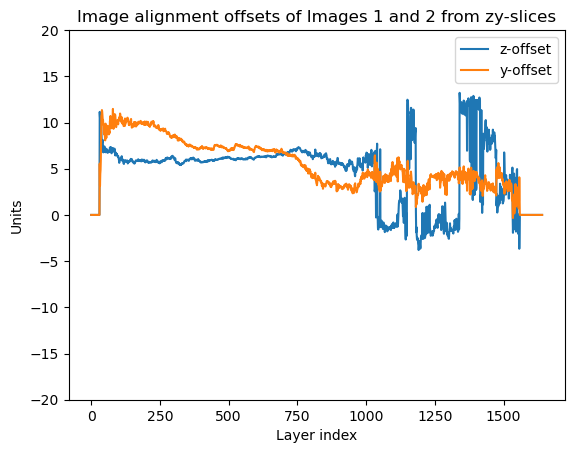

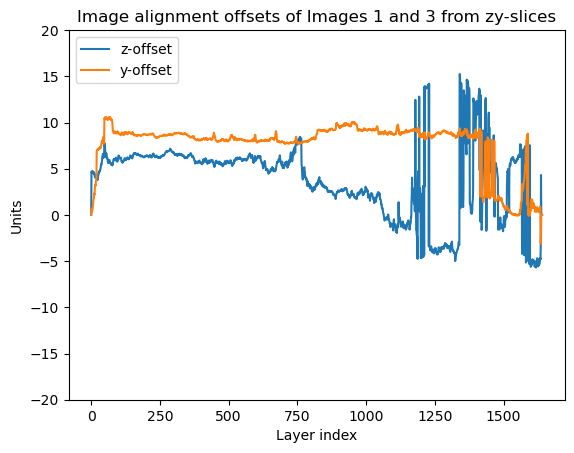

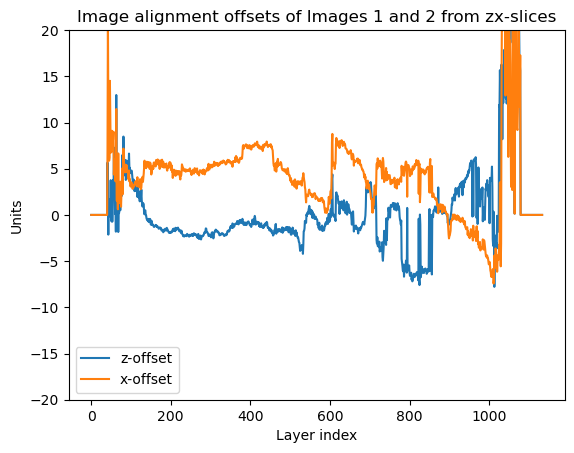

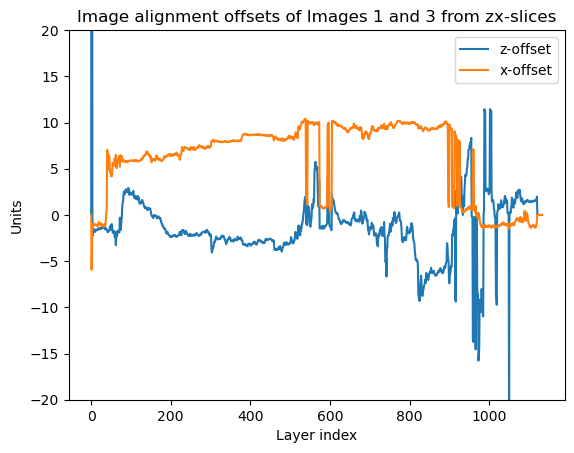

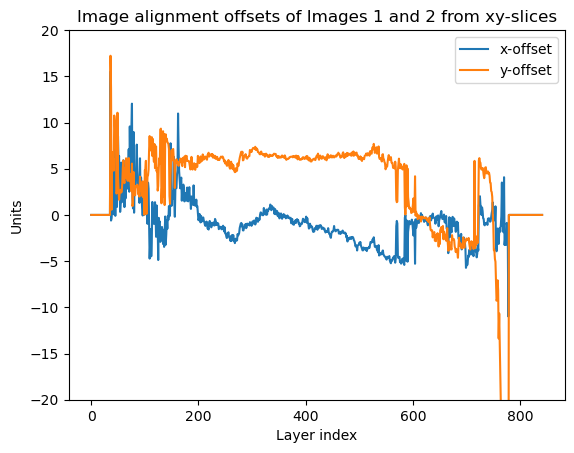

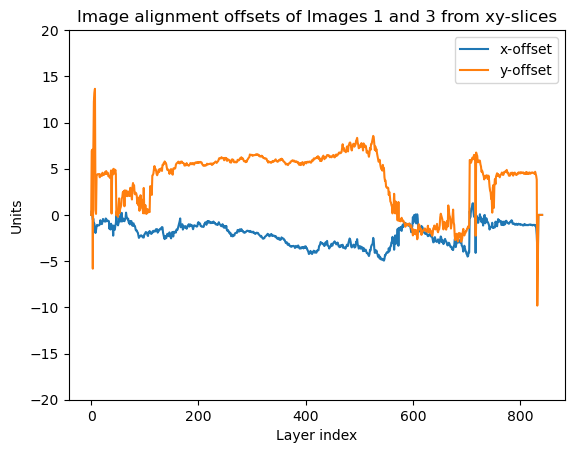

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(file_path:str, title:str, label1:str, label2:str):
    with open(file_path, "r") as file:
        line = file.readline()

        x_offset = [0]
        y_offset = [0]

        while line:
            if "Skipped" in line:
                x_offset.append(0)
                y_offset.append(0)
                line = file.readline()
                continue
            s = line.split(",")
            x_offset.append(float(s[-2][:-1]))
            line = file.readline()
            s = line.split(",")
            y_offset.append(float(s[-2][:-1]))
            line = file.readline()
            # skip last line
            line = file.readline()

        plt.plot(range(len(x_offset)), x_offset, label=label1)
        plt.plot(range(len(y_offset)), y_offset, label=label2)
        plt.title(title)
        plt.xlabel("Layer index")
        plt.ylabel("Units")
        plt.ylim((-20, 20))
        plt.legend()
        plt.show()

plot_data("D:/BMAP/Brain 4/offsets/zy_matrices_im12.txt", "Image alignment offsets of Images 1 and 2 from zy-slices", "z-offset", "y-offset")
plot_data("D:/BMAP/Brain 4/offsets/zy_matrices_im13.txt", "Image alignment offsets of Images 1 and 3 from zy-slices", "z-offset", "y-offset")
plot_data("D:/BMAP/Brain 4/offsets/zx_matrices_im12.txt", "Image alignment offsets of Images 1 and 2 from zx-slices", "z-offset", "x-offset")
plot_data("D:/BMAP/Brain 4/offsets/zx_matrices_im13.txt", "Image alignment offsets of Images 1 and 3 from zx-slices", "z-offset", "x-offset")
plot_data("D:/BMAP/Brain 4/offsets/xy_matrices_im12.txt", "Image alignment offsets of Images 1 and 2 from xy-slices", "x-offset", "y-offset")
plot_data("D:/BMAP/Brain 4/offsets/xy_matrices_im13.txt", "Image alignment offsets of Images 1 and 3 from xy-slices", "x-offset", "y-offset")

In [ ]:
cha1 = TifStack("D:/BMAP/Brain X/cha1_8b").as_3d_numpy()
cha2 = TifStack("D:/BMAP/Brain X/cha2_8b").as_3d_numpy()
cha3 = TifStack("D:/BMAP/Brain X/cha3_8b").as_3d_numpy()

In [2]:
from numpy import ndarray, array, concatenate, zeros, pad

# pads arr with zeroes evenly (as possible) on all sides to match pad_shape
def pad_to_shape(pad_shape: tuple, arr: ndarray):
    assert len(pad_shape) == len(arr.shape)
    pad_dim = [pad_shape[i] - arr.shape[i] for i in range(len(pad_shape))]
    pad0 = list(map(lambda x: (x // 2, (x + 1) // 2), pad_dim))
    return pad(arr, pad_width=pad0, mode='constant')

# similar to numpy.roll(), but numbers moved to the other side are lost and replaced with zeroes.
def roll_pad(arr: ndarray, move: int, axis: int = 0):
    if axis > len(arr.shape) - 1 or axis < 0: raise Exception
    if move == 0: return arr
    if axis != 0:
        for s in range(arr.shape[0]): arr[s] = roll_pad(arr[s], move, axis - 1)
        return arr
    if move > 0: return concatenate((zeros((move,) + arr[0].shape), arr[:-move]))
    else: return concatenate((arr[-move:], zeros((-move,) + arr[0].shape)))

# gets a plane from a 3d image
def get_layer(
    index: int,          # layer of image requested
    image: ndarray,      # 3-D image (use TifStack.as_3d_numpy())
    plane = "xy",        # must be "xy", "yx", "xz", "zx", "yz", "zy"
    img_format = "zyx",  # xyz in some order
):
    # guards
    if plane not in {"xy", "yx", "xz", "zx", "yz", "zy"} or img_format not in {"zyx", "zxy", "yxz", "yzx", "xyz", "xzy"}:
        print(f"Invalid plane selected in get_layer().  Plane: {plane}, Layer: {index}, Img_format: {img_format}\nReturning to caller...")
        return None

    # get the layer
    if 'x' not in plane:   sub = img_format.index('x')
    elif 'y' not in plane: sub = img_format.index('y')
    elif 'z' not in plane: sub = img_format.index('z')

    if sub == 0:   layer_image = image[index, :, :]
    elif sub == 1: layer_image = image[:, index, :]
    elif sub == 2: layer_image = image[:, :, index]

    # if plane is flipped compared to image format, return the transpose.
    if plane not in (img_format[:sub] + img_format[sub + 1:]):
        return layer_image.transpose()
    return layer_image

# returns alignment matrices for aligning 3d images based on a 2d plane
def get_offsets(
        images: list[ndarray],
        plane: str,
        verbose=False,
):
    assert(len(images) > 1)
    assert(plane in {'xy', 'xz', 'yz'})

    if plane == 'xy':   img_reference_idx = images[0].shape[0] // 2
    elif plane == 'xz': img_reference_idx = images[0].shape[1] // 2
    elif plane == 'yz': img_reference_idx = images[0].shape[2] // 2
    # print(f"img_reference_idx: {img_reference_idx}")

    img_samples = []

    for image in images:
        img_samples.append(get_layer(img_reference_idx, image, plane))

    if verbose:
        print("---------")
        for k in img_samples:
            print(k.shape)
        print("#########")

    with Pool(len(images)) as pool:
        img_samples = list(pool.map(get_gradient, img_samples))

    assert all([img is not None for img in img_samples])

    # I added a verbose argument to get_transformation_matrix. If that is causing errors, just delete the argument.
    transformation_matrices = [get_transformation_matrix(img_samples[0], img, verbose=verbose) for img in img_samples[1:]]
    del img_samples
    return transformation_matrices

# aligns images in 3d, using 2d alignment algorithm as a blackbox
def align_images(img1: ndarray, img2: ndarray, max_iter: int = 50, verbose=False):
    # make images the same size
    pad_size = tuple((max(i) for i in zip(img1.shape, img2.shape)))

    img1 = pad_to_shape(pad_size, img1)
    img2 = pad_to_shape(pad_size, img2)

    if verbose:
        print("Loaded images.")
        print("Resized shapes: " + str(img1.shape))

    # instantiate variables
    iteration = 0
    residual = None

    x_moves = []
    y_moves = []
    z_moves = []

    # iterate until converge
    while iteration < max_iter:
        if verbose: print(f"Iteration {iteration}")
        xy_matrix = get_offsets([img1, img2], "xy")

        x_moves.append(-int(xy_matrix[0][0][2]))
        y_moves.append(-int(xy_matrix[0][1][2]))

        img2 = roll_pad(img2, x_moves[-1], axis=2)
        img2 = roll_pad(img2, y_moves[-1], axis=1)

        yz_matrix = get_offsets([img1, img2], "yz", verbose=verbose)
        xz_matrix = get_offsets([img1, img2], "xz", verbose=verbose)

        x_moves.append(-int(xz_matrix[0][0][2]))
        y_moves.append(int(yz_matrix[0][1][2]))
        z_moves.append(int((xz_matrix[0][1][2] + yz_matrix[0][0][2]) / 2))

        if verbose:
            print(x_moves[-1])
            print(y_moves[-1])
            print(z_moves[-1])

        img2 = roll_pad(img2, x_moves[-1], axis=2)
        img2 = roll_pad(img2, y_moves[-1], axis=1)
        img2 = roll_pad(img2, z_moves[-1], axis=0)

        iteration += 1

        if x_moves[-1] == 0 and y_moves[-1] == 0 and z_moves[-1] == 0:
            residual = (-xz_matrix[0][0][2], yz_matrix[0][1][2], (xz_matrix[0][1][2] + yz_matrix[0][0][2]) / 2)
            if verbose:
                print("Images converged.")
                print("Residual: " + str(residual))
            break

    return x_moves, y_moves, z_moves, residual


In [3]:
#################### CHANGE THESE FILE PATHS #########################
cha1 = TifStack("D:/BMAP/Brain X/cha1_8b").as_3d_numpy()
cha2 = TifStack("D:/BMAP/Brain X/cha2_8b").as_3d_numpy()
cha3 = TifStack("D:/BMAP/Brain X/cha3_8b").as_3d_numpy()
max_iterations = 50
######################################################################

img2_x_moves, img2_y_moves, img2_z_moves, img2_residual = align_images(cha1, cha2, max_iterations, verbose=True)
img3_x_moves, img3_y_moves, img3_z_moves, img3_residual = align_images(cha1, cha3, max_iterations, verbose=True)

print("Image 2:")
print("x: " + str(img2_x_moves))
print("y: " + str(img2_y_moves))
print("z: " + str(img2_z_moves))
print("Image 3:")
print("x: " + str(img3_x_moves))
print("y: " + str(img3_y_moves))
print("z: " + str(img3_z_moves))
print("Residuals:")
print("Image 2: " + str(img2_residual))
print("Image 3: " + str(img3_residual))

Loaded images.
Resized shapes: (791, 1132, 1272)
Iteration 0
---------
(1132, 791)
(1132, 791)
#########
downsampling factor for transformation_matrix 1
[[1.   0.   2.09]
 [0.   1.   0.5 ]
 [0.   0.   1.  ]]
---------
(1272, 791)
(1272, 791)
#########
downsampling factor for transformation_matrix 1
[[1.   0.   0.01]
 [0.   1.   0.58]
 [0.   0.   1.  ]]
0
0
1
Iteration 1
---------
(1132, 791)
(1132, 791)
#########
downsampling factor for transformation_matrix 1
[[1.   0.   1.14]
 [0.   1.   0.46]
 [0.   0.   1.  ]]
---------
(1272, 791)
(1272, 791)
#########
downsampling factor for transformation_matrix 1
[[ 1.    0.   -0.95]
 [ 0.    1.    0.61]
 [ 0.    0.    1.  ]]
0
0
0
Images converged.
Residual: (0.9521531, 0.4640711, 0.8778509497642517)
Loaded images.
Resized shapes: (791, 1132, 1271)
Iteration 0
---------
(1132, 791)
(1132, 791)
#########
downsampling factor for transformation_matrix 1
[[ 1.    0.    0.43]
 [ 0.    1.   -1.69]
 [ 0.    0.    1.  ]]
---------
(1271, 791)
(1271, 7

In [ ]:
# make align_images make copy
# function that takes in array of stacks and returns array of offsets
    # choose reference image
# try using mask for better edge detection